</br>
<h1 align="center" style="color:green">Case-Based Hands-On EDA Activity</br> UK-based Online Gift Retailer Dataset</h1>
<div style="text-align:center">Prepared by <b>Kirk T. Braga, Jan Vincent G. Elleazar, Michael Suacito, and Carl Jacob Mateo</b><br>
CSELEC3C - Data Analysis and Visualization <br>
<b>UST College of Information and Computing Sciences</b>
</div>

***
## Scenario
You’ve been hired as a junior data-analytics duo at a UK-based online gift retailer. The CEO wants to understand what truly drives revenue and returns across two years of transactions to guide Q4 promotions and inventory buys. Your job is to clean, explore, and explain the dataset—surfacing patterns by product, country, customers, and time.

## Learning Outcomes
- Clean messy transaction data and build derived fields for retail EDA.
- Summarize and visualize customers, orders, products, countries, and time.
- Quantify returns and their impact on revenue and top products.
- Communicate insights with clear plots and a short slide story.
***

# Step-by-Step Tasks
## 1) Project setup
Create a folder: ```retail_eda_pair_Surname1_Surname2/``` <br>
Subfolders: ```notebooks/```, ```figures/```, ```reports/```, ```exports/```.
## 2) Load & union the data
- Load both sheets and concatenate into a single table.
- Parse ```InvoiceDate``` as datetime (it includes time of day).
- Add a column ```YearSheet``` showing the source sheet (2009–2010 vs 2010–2011) for comparisons.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load csv dataset
data1 = pd.read_csv('online_retail_II.xlsx - Year 2009-2010.csv')
data2 = pd.read_csv('online_retail_II.xlsx - Year 2010-2011.csv')
# Note: Adjust the file paths on your system as needed

# Concatenate datasets
data = pd.concat([data1, data2], ignore_index=True)

# Parse InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Add a column 'YearSheet' showing the source sheet (2009-2010 vs 2010-2011)
data['YearSheet'] = np.where(data['InvoiceDate'].dt.year == 2009, '2009-2010', '2010-2011')

# Display the first few rows of the combined dataset
print(data.head())
print("\n")
# Display the last few rows of the combined dataset
print(data.tail())

/var/folders/vs/zcjd1wds7_78_tmdl741y03m0000gn/T/ipykernel_4583/222971915.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])


  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  YearSheet  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  2009-2010  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  2009-2010  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  2009-2010  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  2009-2010  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  2009-2010  


        Invoice StockCode                      Description  Quantity  \
1067366  581587     22899     CHILDREN'S APRON DOLLY GIRL          6   
1067367

## 3) Basic cleaning
- Drop exact duplicate rows.
- Handle missing Customer ID (report % missing; keep for product/country EDA, but exclude from customer-level analyses).
- Remove or flag zero/negative Price rows (report counts).
- Create returns flag: Is_Return = Quantity < 0.
- Create Revenue: Revenue = Quantity * Price (negative revenue for returns).

In [2]:
# Drop exact duplicate rows
data = data.drop_duplicates()

# Report percentage of missing Customer ID
missing_customer_id_pct = data['Customer ID'].isna().mean() * 100
print(f"Percentage of missing Customer ID: {missing_customer_id_pct:.2f}%")

# Check for missing customer IDs again
missing_customer_id_pct = data['Customer ID'].isna().mean() * 100
print(f"Percentage of missing Customer ID after removal: {missing_customer_id_pct:.2f}%")

# Flag zero/negative Price rows
zero_negative_price_count = (data['Price'] <= 0).sum()
print(f"Count of zero/negative Price rows: {zero_negative_price_count}")

# Remove rows with zero/negative Price
data = data[data['Price'] > 0]

# Check for zero/negative Price rows again
zero_negative_price_count = (data['Price'] <= 0).sum()
print(f"Count of zero/negative Price rows after removal: {zero_negative_price_count}")

# Create returns flag
data['Is_Return'] = data['Quantity'] < 0

# Show counts of returns vs non-returns
returns_counts = data['Is_Return'].value_counts()
print("Counts of returns vs non-returns:")
print(returns_counts)

# Create Revenue column (negative revenue for returns)
data['Revenue'] = data['Quantity'] * data['Price']

# Confirm no Price <= 0 rows
zero_negative_price_count = (data['Price'] <= 0).sum()
print(f"Final check - Count of zero/negative Price rows: {zero_negative_price_count}")

print('--------------------------------')

# Display the first few rows of the cleaned dataset
print(data.head())

# Display the last few rows of the cleaned dataset
print(data.tail())

Percentage of missing Customer ID: 22.76%
Percentage of missing Customer ID after removal: 22.76%
Count of zero/negative Price rows: 6019
Count of zero/negative Price rows after removal: 0
Counts of returns vs non-returns:
Is_Return
False    1007914
True       19103
Name: count, dtype: int64
Final check - Count of zero/negative Price rows: 0
--------------------------------
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  YearSheet  \
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  2009-2010   
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom 

## 4) Time features
From ``InvoiceDate``, derive:
- ``Year, Quarter, Month, DayOfWeek, Hour``
- ``InvoiceDateFloorMonth`` (month start) for monthly rollups. 

Checks:
- Value counts for ``Hour`` and ``DayOfWeek`` to see busy times.

In [3]:
# Insert code for time features here

# Year, Quarter, Month, DayOfWeek, Hour columns
data['Year'] = data['InvoiceDate'].dt.year
data['Quarter'] = data['InvoiceDate'].dt.quarter
data['Month'] = data['InvoiceDate'].dt.month
data['Day'] = data['InvoiceDate'].dt.day
data['Hour'] = data['InvoiceDate'].dt.hour

# InvoiceDateFloorMonth (month start) for monthly rollups
data['InvoiceDateFloorMonth'] = data['InvoiceDate'].dt.to_period('M')

# check data
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,YearSheet,Is_Return,Revenue,Year,Quarter,Month,Day,Hour,InvoiceDateFloorMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-2010,False,83.4,2009,4,12,1,7,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-2010,False,81.0,2009,4,12,1,7,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-2010,False,81.0,2009,4,12,1,7,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009-2010,False,100.8,2009,4,12,1,7,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-2010,False,30.0,2009,4,12,1,7,2009-12


In [4]:
# Value counts for Hour and DayOfWeek to see busy times.
hour_counts = data['Hour'].value_counts().sort_index()
# print(hour_counts)

day_counts = data['Day'].value_counts().sort_index()
# print(day_counts)

## 5) Orders & customers
- Define order level by ``Invoice`` (each invoice is an order).
- Compute AOV (Average Order Value), items per order, and orders per customer (where ``Customer ID`` exists).
- Classify customers: New vs Repeat per sheet-year (first purchase month per customer).

Outputs:
- Table: ``n_orders, n_customers (non-null), AOV, items_per_order`` per ``YearSheet``.
- Bar chart: New vs Repeat revenue share per ``YearSheet``.

In [5]:
# Insert code for orders & customers here

# Create orders table
orders = (
    data.groupby('Invoice')
    .agg(
        Customer_ID=('Customer ID', 'first'),
        YearSheet=('YearSheet', 'first'),
        Revenue=('Revenue', 'sum'),
        Items=('Quantity', 'sum')
    )
    .reset_index()
)
orders.head()

,Invoice,Customer_ID,YearSheet,Revenue,Items
0,489434,13085.0,2009-2010,505.30,166
1,489435,13085.0,2009-2010,145.80,60
2,489436,13078.0,2009-2010,630.33,193
3,489437,15362.0,2009-2010,310.75,145
4,489438,18102.0,2009-2010,2286.24,826


In [6]:
# AOV, items_per_order, n_orders, n_customers
order_stats = (
    orders.groupby('YearSheet')
    .agg(
        AOV=('Revenue', 'mean'),
        avg_items_per_order=('Items', 'mean'),
        n_orders=('Invoice', 'nunique'),
        n_customers=('Customer_ID', 'nunique')
    )
    .reset_index()
)

order_stats.head()

,YearSheet,AOV,avg_items_per_order,n_orders,n_customers
0,2009-2010,382.452472,199.445511,2083,1045
1,2010-2011,393.586859,222.807847,46286,5839


In [7]:
# avg_orders_per_customer
orders_per_customer = (
    orders.dropna(subset=['Customer_ID'])
    .groupby(['YearSheet', 'Customer_ID'])
    .agg(n_orders=('Invoice', 'nunique'))
    .groupby('YearSheet')['n_orders'].mean()
    .reset_index()
    .rename(columns={'n_orders': 'avg_orders_per_customer'})
)
orders_per_customer.head()

,YearSheet,avg_orders_per_customer
0,2009-2010,1.818182
1,2010-2011,7.359137


In [8]:
# combine the tables
order_stats = order_stats.merge(orders_per_customer, on='YearSheet', how='left')
order_stats.head()

,YearSheet,AOV,avg_items_per_order,n_orders,n_customers,avg_orders_per_customer
0,2009-2010,382.452472,199.445511,2083,1045,1.818182
1,2010-2011,393.586859,222.807847,46286,5839,7.359137


In [9]:
# Get classify 'New' and 'Repeat'
first_purchase = (
    data.dropna(subset=['Customer ID'])
    .groupby('Customer ID')['Invoice']
    .min()
    .reset_index()
    .rename(columns={'Invoice': 'FirstInvoice'})
)

# Attach to orders
data = data.merge(first_purchase, on='Customer ID', how='left')

# Customer type per YearSheet
data['CustomerType'] = np.where(
    data['Invoice'] == data['FirstInvoice'],
    'New',
    'Repeat'
)

In [10]:
first_purchase.head()

,Customer ID,FirstInvoice
0,12346.0,491725
1,12347.0,529924
2,12348.0,524140
3,12349.0,506394
4,12350.0,543037


In [11]:
data['CustomerType'].value_counts()

CustomerType
Repeat    883341
New       143676
Name: count, dtype: int64

In [12]:
y1 = data[(data['YearSheet'] == '2009-2010')]['CustomerType'].value_counts()
y2 = data[(data['YearSheet'] == '2010-2011')]['CustomerType'].value_counts()

In [13]:
y2

CustomerType
Repeat    859777
New       122774
Name: count, dtype: int64

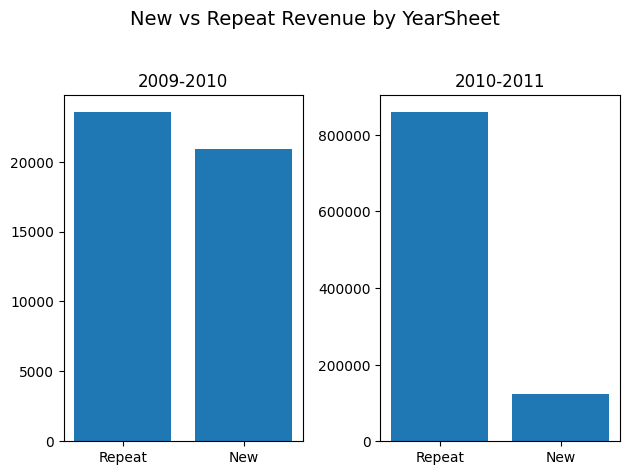

In [14]:
import warnings
warnings.filterwarnings("ignore")

labels = ['Repeat', 'New']

fig, ax = plt.subplots(1, 2)

ax[0].set_title('2009-2010')
ax[0].bar(x=labels, height=y1)

ax[1].set_title('2010-2011')
ax[1].bar(x=labels, height=y2);

fig.suptitle('New vs Repeat Revenue by YearSheet', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave room for suptitle
plt.show()

## 6) Product & country profiles
- Top 10 products by revenue (exclude returns; show ``StockCode, Description, Revenue, Quantity``).
- Top 10 countries by revenue and share of total (show UK vs non-UK split).
- Return-prone products: top items by return rate = (abs(negative Qty) / total Qty), min 200 units sold threshold.

Outputs:
- Two ranked tables (products & countries).
- One chart: UK vs Rest-of-World revenue share.

In [15]:
# Insert code for product & country profiles here
top_products = (
    data.loc[~data['Is_Return']]
    .groupby(['StockCode', 'Description'], as_index=False)
    .agg({'Revenue': 'sum', 'Quantity': 'sum'})
    .sort_values('Revenue', ascending=False)
)

top_ten_products = top_products.head(10)

In [16]:
country_revenue = (
    data.loc[~data['Is_Return']]
    .groupby('Country', as_index=False)['Revenue']
    .sum()
    .sort_values('Revenue', ascending=False)
)

# Compute share of total revenue
total_revenue = country_revenue['Revenue'].sum()
country_revenue['Share'] = country_revenue['Revenue'] / total_revenue

top_countries = country_revenue.head(10)

top_countries

,Country,Revenue,Share
40,United Kingdom,1.741057e+07,0.850265
11,EIRE,6.587673e+05,0.032172
26,Netherlands,5.540381e+05,0.027057
15,Germany,4.250197e+05,0.020756
14,France,3.504561e+05,0.017115
0,Australia,1.692835e+05,0.008267
34,Spain,1.083325e+05,0.005291
36,Switzerland,1.006856e+05,0.004917
35,Sweden,9.186982e+04,0.004487
10,Denmark,6.858069e+04,0.003349


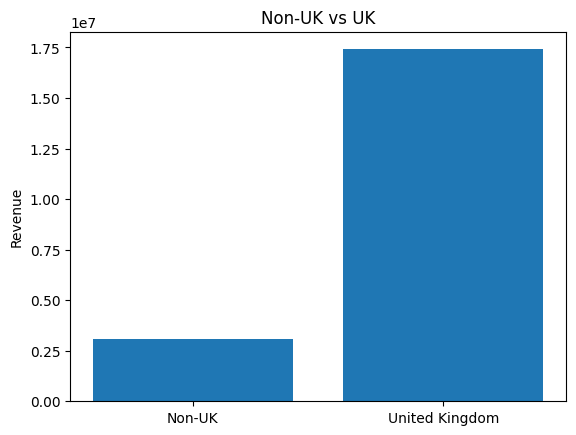

In [17]:
comparison = (
    data.loc[~data['Is_Return']]
    .assign(Group=lambda x: x['Country'].where(x['Country'] == 'United Kingdom', 'Non-UK'))
    .groupby('Group', as_index=False)['Revenue']
    .sum()
)

plt.bar(comparison['Group'], comparison['Revenue'])
plt.title("Non-UK vs UK")
plt.ylabel("Revenue")
plt.show()

In [18]:
# Separate returns vs sales
returns = data.loc[data['Is_Return']].groupby('StockCode')['Quantity'].sum().abs()
sales = data.loc[~data['Is_Return']].groupby('StockCode')['Quantity'].sum()

# Merge & compute return rate
return_prone = (
    pd.concat([sales, returns], axis=1, keys=['TotalQty', 'ReturnQty'])
    .fillna(0)
    .query("TotalQty >= 200")
    .assign(ReturnRate=lambda x: x['ReturnQty'] / x['TotalQty'])
    .sort_values('ReturnRate', ascending=False)
)

return_prone.head()

,TotalQty,ReturnQty,ReturnRate
StockCode,,,
79323B,242.0,248.0,1.024793
23843,80995.0,80995.0,1.000000
20715,400.0,400.0,1.000000
23166,78033.0,74494.0,0.954647
72045D,539.0,504.0,0.935065


## 7) Time-series EDA
- Monthly revenue line for the full period (net of returns). Annotate visible spikes/dips.
- Seasonality: average revenue by Month (1–12) over the two years.
- Intra-day pattern: average revenue by Hour (optional if time granularity is adequate).

Outputs:
- Line chart: monthly revenue (with returns accounted for).
- Bar/line: revenue by month number (seasonality).
- Line: revenue by hour.

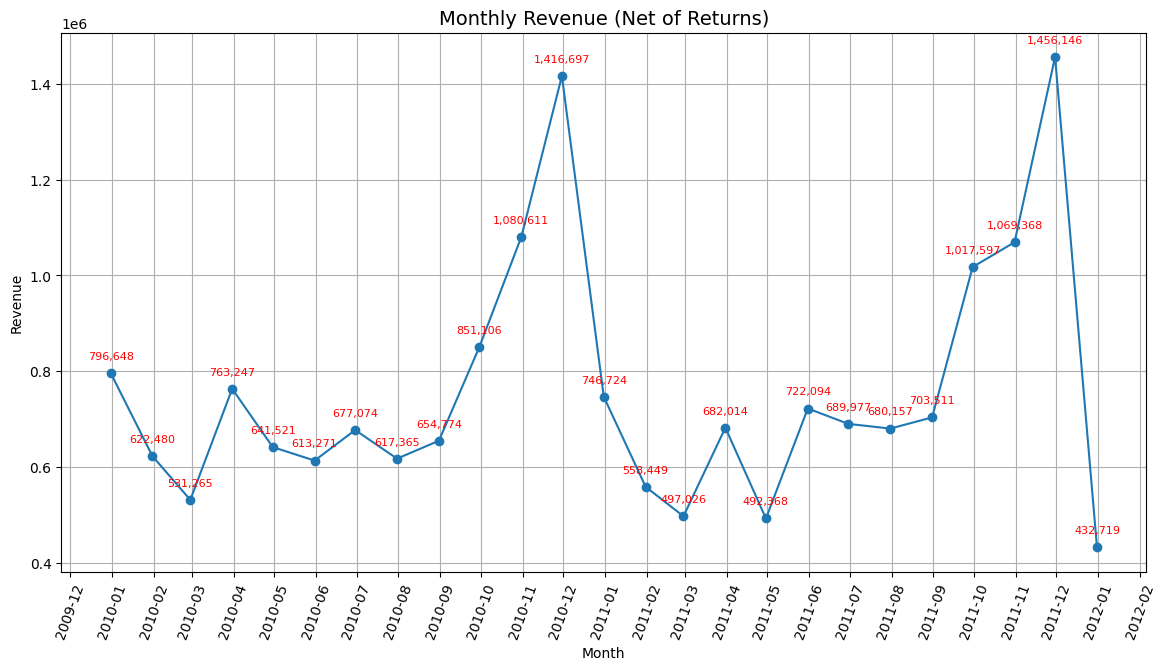

In [19]:
import matplotlib.dates as mdates

monthly_revenue = (
    data.groupby(pd.Grouper(key='InvoiceDate', freq='M'))['Revenue']
    .sum()
    .reset_index()
)

plt.figure(figsize=(14,7))
plt.plot(monthly_revenue['InvoiceDate'], monthly_revenue['Revenue'], marker='o')
plt.title("Monthly Revenue (Net of Returns)", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  
plt.xticks(rotation=70)  

for i in monthly_revenue.itertuples():
    plt.annotate(f"{i.Revenue:,.0f}", 
                 (i.InvoiceDate, i.Revenue), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center', 
                 fontsize=8, 
                 color="red")
plt.show()





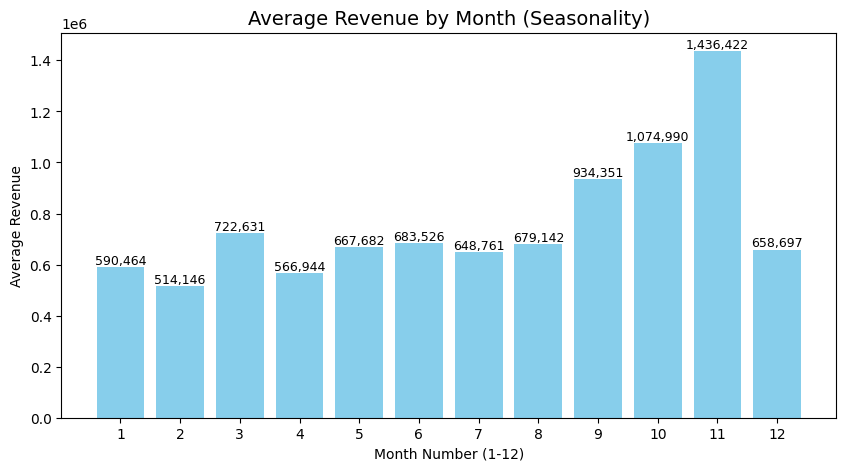

In [20]:
# Seasonality: Average revenue by Month (1–12)
monthly_revenue['MonthNum'] = monthly_revenue['InvoiceDate'].dt.month
seasonality = monthly_revenue.groupby('MonthNum')['Revenue'].mean().reset_index()

plt.figure(figsize=(10,5))
bars = plt.bar(seasonality['MonthNum'], seasonality['Revenue'], color='skyblue')
plt.title("Average Revenue by Month (Seasonality)", fontsize=14)
plt.xlabel("Month Number (1-12)")
plt.ylabel("Average Revenue")
plt.xticks(range(1,13))

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,   # x position (center of bar)
        height,                            # y position (top of bar)
        f"{height:,.0f}",                  # formatted value
        ha='center', va='bottom', fontsize=9, color="black"
    )
plt.show()

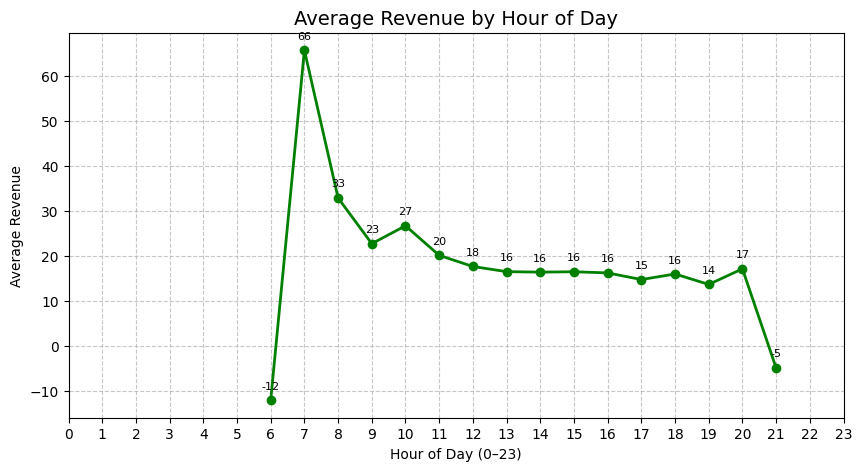

In [21]:
# Intra-day pattern: Average revenue by Hour
data['Hour'] = data['InvoiceDate'].dt.hour

hourly = (
    data.groupby('Hour')['Revenue']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,5))
plt.plot(hourly['Hour'], hourly['Revenue'], marker='o', color='green', linewidth=2)
plt.title("Average Revenue by Hour of Day", fontsize=14)
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Average Revenue")
plt.xticks(range(0,24))
plt.grid(True, linestyle="--", alpha=0.7)

# Annotate each point with its value
for i in hourly.itertuples():
    plt.annotate(f"{i.Revenue:,.0f}",
                 (i.Hour, i.Revenue),
                 textcoords="offset points",
                 xytext=(0,8),
                 ha='center',
                 fontsize=8,
                 color="black")

plt.show()


## 8) Returns analysis
- Overall return rate = (sum of negative Quantity) / (sum of abs(Quantity)).
- Return impact on revenue (sum of negative Revenue vs net revenue).
- Returns by Country and Top 10 products (from §6).

Outputs:
- Table: return rate & revenue impact (overall, by country).
- Short paragraph: business impact & hypotheses (e.g., product quality, shipping damages, wrong descriptions).

In [22]:
# Overall return rate
total_returns_qty = data.loc[data['Quantity'] < 0, 'Quantity'].sum()
total_abs_qty = data['Quantity'].abs().sum()
return_rate = total_returns_qty / total_abs_qty

# Return impact on revenue 
negative_revenue = data.loc[data['Revenue'] < 0, 'Revenue'].sum()
net_revenue = data['Revenue'].sum()
revenue_impact_pct = negative_revenue / net_revenue

# Returns by Country
returns_country = (
    data.groupby('Country')
        .agg(
            ReturnQty=('Quantity', lambda x: x[x < 0].sum()),
            TotalQty=('Quantity', lambda x: x.abs().sum()),
            ReturnRev=('Revenue', lambda x: x[x < 0].sum()),
            NetRev=('Revenue', 'sum')
        )
        .reset_index()
)

returns_country['ReturnRate'] = returns_country['ReturnQty'] / returns_country['TotalQty']
returns_country['RevenueImpact'] = returns_country['ReturnRev'] / returns_country['NetRev']
returns_country = returns_country.sort_values('ReturnRate', ascending=True)
returns_country_display = returns_country.copy()
returns_country_display['ReturnRate'] = (returns_country_display['ReturnRate'] * 100).map("{:.2f}%".format)
returns_country_display['RevenueImpact'] = (returns_country_display['RevenueImpact'] * 100).map("{:.2f}%".format)

# Top 10 returned products
returns_products = (
    data[data['Quantity'] < 0]
    .groupby(['StockCode', 'Description'])
    .agg(
        ReturnQty=('Quantity', 'sum'),
        ReturnRev=('Revenue', 'sum')
    )
    .reset_index()
    .sort_values('ReturnQty', ascending=True)  # negative = more returns
    .head(10)
)


overall_table = pd.DataFrame({
    "Return Rate": [f"{return_rate:.2%}"],
    "Revenue Impact": [f"{revenue_impact_pct:.2%}"]

}, index=["Overall Return Metrics"])
display(overall_table)

print("📊 Returns by Country:")
display(returns_country_display[['Country', 'ReturnRate', 'RevenueImpact']].head(10))

print("\n📊 Top 10 Returned Products:")
display(returns_products)

# Short Business Impact Paragraph
impact_text = f"""
Overall return rate is {return_rate:.2%}, meaning that roughly {abs(total_returns_qty):,} items out of
{total_abs_qty:,} sold were returned. Returns reduced revenue by {abs(revenue_impact_pct):.2%},
a significant drag on profitability. Countries with lower return rates may indicate stronger
customer satisfaction, better shipping conditions, or product-market fit. Conversely, higher
return rates in some regions could stem from shipping delays, damages, or mismatched expectations.
At the product level, items with the highest return volumes may reveal issues in product quality,
descriptions, or packaging. Addressing these issues can directly reduce returns and protect margins.
"""
print(impact_text)


,Return Rate,Revenue Impact
Overall Return Metrics,-4.08%,-7.69%


📊 Returns by Country:


,Country,ReturnRate,RevenueImpact
27,Nigeria,-31.33%,2207.96%
14,France,-24.94%,-8.93%
38,USA,-22.91%,-33.09%
22,Korea,-12.72%,-17.76%
9,Czech Republic,-10.53%,-16.82%
34,Spain,-10.10%,-19.03%
39,United Arab Emirates,-7.49%,-11.55%
32,Saudi Arabia,-5.88%,-11.24%
2,Bahrain,-4.56%,-8.68%
21,Japan,-4.54%,-8.48%



📊 Top 10 Returned Products:


,StockCode,Description,ReturnQty,ReturnRev
2177,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,-168469.60
1918,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74494,-77479.64
2518,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9381,-330.45
297,21088,SET/6 FRUIT SALAD PAPER CUPS,-7140,-572.52
301,21096,SET/6 FRUIT SALAD PAPER PLATES,-7008,-911.04
3082,M,Manual,-5444,-422926.14
29,16047,POP ART PEN CASE & PENS,-5184,-414.72
2851,85110,BLACK SILVER FLOWER T-LIGHT HOLDER,-5040,-387.36
2223,37340,MULTICOLOUR SPRING FLOWER MUG,-4996,-501.22
28,16046,TEATIME PEN CASE & PENS,-4632,-389.04



Overall return rate is -4.08%, meaning that roughly 476,820 items out of
11,681,969 sold were returned. Returns reduced revenue by 7.69%,
a significant drag on profitability. Countries with lower return rates may indicate stronger
customer satisfaction, better shipping conditions, or product-market fit. Conversely, higher
return rates in some regions could stem from shipping delays, damages, or mismatched expectations.
At the product level, items with the highest return volumes may reveal issues in product quality,
descriptions, or packaging. Addressing these issues can directly reduce returns and protect margins.



## 9) Customer-level snapshots (where ``Customer ID`` is present)
- RFM-style quick view (no need to segment):
- Recency (days since last purchase at dataset end), Frequency (# invoices), Monetary (total net revenue).
- Histograms for R, F, M with brief observations.

Outputs:
- Three small histograms + 3 bullets of commentary (e.g., “Most customers are low-frequency one-time buyers; long tail of high-value repeaters.”)

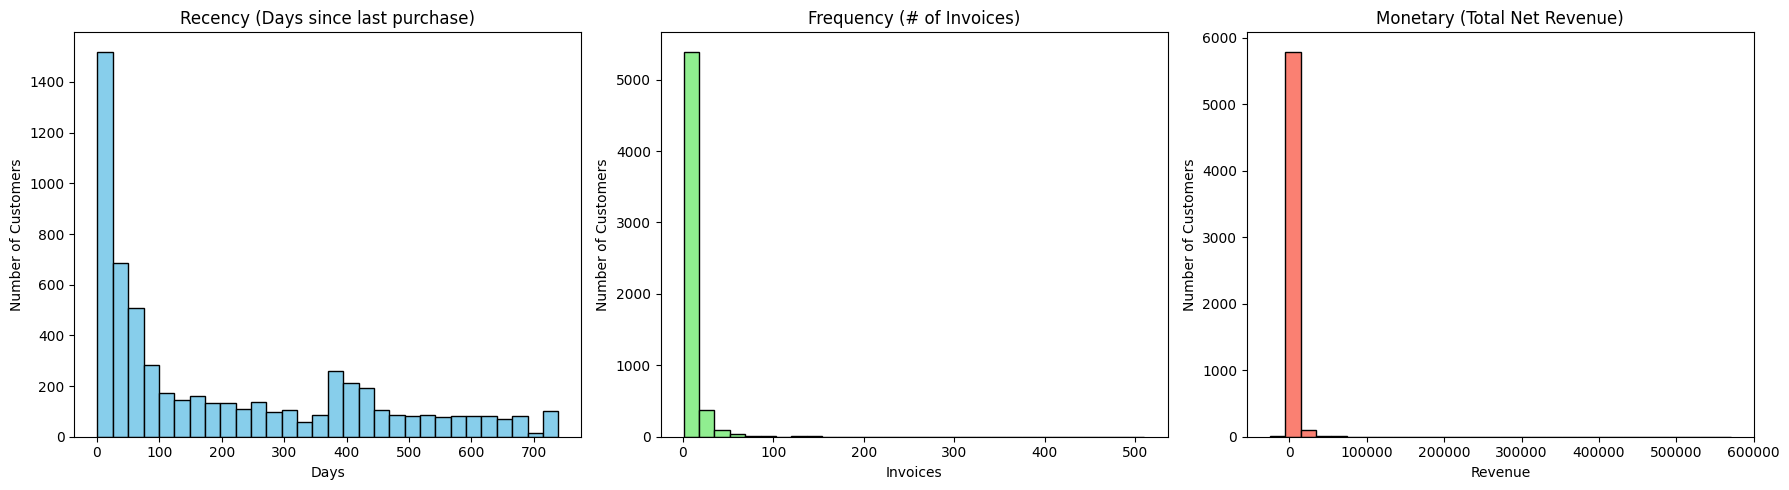

In [23]:
from datetime import timedelta

# Filter to customers with IDs
cust_data = data.dropna(subset=['Customer ID']).copy()

# Define dataset end date
end_date = cust_data['InvoiceDate'].max() + timedelta(days=1)

# Compute RFM
rfm = (
    cust_data.groupby('Customer ID')
    .agg(
        Recency=('InvoiceDate', lambda x: (end_date - x.max()).days),
        Frequency=('Invoice', 'nunique'), 
        Monetary=('Revenue', 'sum')
    )
    .reset_index()
)

# Histograms
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# Recency
axes[0].hist(rfm['Recency'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title("Recency (Days since last purchase)")
axes[0].set_xlabel("Days")
axes[0].set_ylabel("Number of Customers")

# Frequency
axes[1].hist(rfm['Frequency'], bins=30, color='lightgreen', edgecolor='black')
axes[1].set_title("Frequency (# of Invoices)")
axes[1].set_xlabel("Invoices")
axes[1].set_ylabel("Number of Customers")

# Monetary
axes[2].hist(rfm['Monetary'], bins=30, color='salmon', edgecolor='black')
axes[2].set_title("Monetary (Total Net Revenue)")
axes[2].set_xlabel("Revenue")
axes[2].set_ylabel("Number of Customers")

plt.tight_layout()
plt.show()



## 10) Synthesis & recommendations
- 5–7 clear insights (each backed by one plot/table).
- 3 actions the retailer could test next month (e.g., “Increase stock for top product X in Country Y; reduce returns for StockCode Z via packaging or description clarity; run a weekend promo at the top revenue hour.”)